In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from pprint import pprint
import warnings
warnings.filterwarnings("ignore") 

# 1. Read Data

In [2]:
df = pd.read_csv('bank+marketing/bank_clean.csv')

# 2. Train Test Split

In [147]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['y'], axis=1), df['y'], test_size = 0.3, random_state = 42)

# 3. Column Transformation
- OneHotEncoder for 'job','marital', 'contact', 'default', 'housing', 'loan', 'contact', 'month','poutcome'
- OrdinalEncoder for education

In [148]:

education_categories = [['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'university.degree','professional.course']]
one_hot_encoding_features = ['job','marital', 'contact', 'default', 'housing', 'loan', 'month','poutcome']

transformer = make_column_transformer(    
    (OneHotEncoder(),one_hot_encoding_features),
    (OrdinalEncoder(categories=education_categories, unknown_value=-1, handle_unknown='use_encoded_value'),['education']),
    remainder = StandardScaler()
)

# 4. Pipeline

In [149]:
pipeline = Pipeline([
    ('transformer', transformer), 
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(random_state=43, max_iter = 1000))),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear', random_state = 43, max_iter = 1000, class_weight='balanced'))
])

## 4.1 GridSearchCV

In [150]:
params = [
    {
        "feature_selection__estimator__penalty": ['l1', 'l2'],
        'feature_selection__estimator__solver': ['liblinear'],
        "feature_selection__estimator__C": [10**n for n in range(-3, 3)],
        "classifier__C": [10**n for n in range(-3, 3)]
    },
    {
        "feature_selection__estimator__penalty": ['None', 'l2'],
        'feature_selection__estimator__solver': ['lbfgs','newton-cg', 'newton-cholesky'],
        "feature_selection__estimator__C": [10**n for n in range(-3, 3)],    
        "classifier__C": [10**n for n in range(-3, 3)]
    }
]
pprint(params)

[{'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
  'feature_selection__estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
  'feature_selection__estimator__penalty': ['l1', 'l2'],
  'feature_selection__estimator__solver': ['liblinear']},
 {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
  'feature_selection__estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
  'feature_selection__estimator__penalty': ['None', 'l2'],
  'feature_selection__estimator__solver': ['lbfgs',
                                           'newton-cg',
                                           'newton-cholesky']}]


In [151]:
cv = GridSearchCV(pipeline, param_grid=params)

# 5. Fitting the LogisticRegression Model

In [152]:
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'contact',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'month',
                                                                          'poutcome']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['illiterate',
                                                                                                     'basic.4y',
                                                                                                     'basic.6y',
                                                                                                     'basic.9y',
                                                                                                     'high.school',
                                                                                                     'university.degree',
                                                                                                     'pr...
                                                              1, 10, 100],
                          'feature_selection__estimator__penalty': ['l1', 'l2'],
                          'feature_selection__estimator__solver': ['liblinear']},
                         {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'feature_selection__estimator__C': [0.001, 0.01, 0.1,
                                                              1, 10, 100],
                          'feature_selection__estimator__penalty': ['None',
                                                                    'l2'],
                          'feature_selection__estimator__solver': ['lbfgs',
                                                                   'newton-cg',
                                                                   'newton-cholesky']}])

In [153]:
pprint(cv.best_params_)

{'classifier__C': 100,
 'feature_selection__estimator__C': 0.1,
 'feature_selection__estimator__penalty': 'l2',
 'feature_selection__estimator__solver': 'newton-cg'}


# 6. Predictions

In [160]:
y_test_pred_2 = cv.predict(X_test)

# 7. Scoring

### 7.1 Accuracy
Q) Out of the predictions made by the model, what percent is correct?
<div align="center">
$Accuracy =\Large \frac{(TP+TN))}{(TP+TN+FP+FN)}$
</div>

In [161]:
accuracy = accuracy_score(y_test_pred_2, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9833292870437809


### 7.2 Precision Score
Q) Out of all the YES predictions, how many of them were correct?
<div align="center">
$Precision = \Large\frac{TP}{TP+FP}$
</div>

In [162]:
p_score = precision_score(y_test_pred_2, y_pred,pos_label='yes')
print("Precision Score:", p_score)

Precision Score: 0.9600706713780919


### 7.3 Recall Score
Q) Of all the actual positive cases, how many did the model capture?
<div align="center">
$Recall = \Large\frac{TP}{TP+FN}$
</div>

In [163]:
r_score = recall_score(y_test_pred_2, y_pred,pos_label='yes')
print("Recall Score", r_score)

Recall Score 0.9669039145907473


### 7.4 F1 Score
<div align="center">
$F1 = \Large\frac{2*TP}{2*TP+FP+FN}$
</div>

In [164]:
f_1_score = f1_score(y_test_pred_2, y_pred, pos_label='yes')
print("F1 Score", f_1_score)

F1 Score 0.9634751773049646


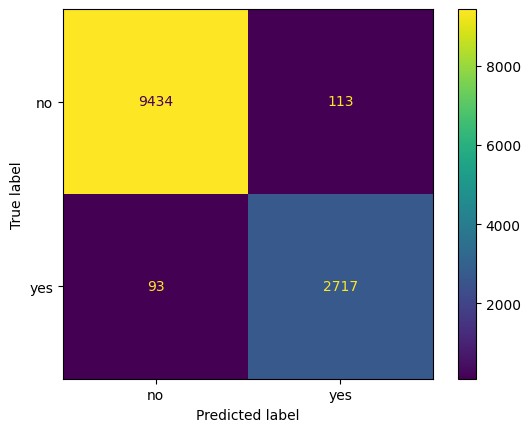

In [165]:
ConfusionMatrixDisplay.from_predictions(y_test_pred_2, y_pred);

In [166]:
best_pipeline = cv.best_estimator_

In [167]:
feature_selector = best_pipeline.named_steps['feature_selection']

In [168]:
selected_mask = feature_selector.get_support()

In [169]:
print(feature_selector.get_feature_names_out())

['x16' 'x17' 'x28' 'x32' 'x33' 'x34' 'x37' 'x39' 'x42' 'x45' 'x46' 'x48'
 'x49']


In [170]:
transformer = best_pipeline.named_steps['transformer']

In [171]:
transform_column = [' '.join(trans.split("__")[1].split('_')) for trans in transformer.get_feature_names_out()]

In [172]:
cols = [x for x, y in zip(transform_column, selected_mask) if y]
len(cols)

13

<div class="alert alert-block alert-success">
    <h3>Logistic Regression - Conclusion</h3>
</div>

- With the combinition of feature selection and LogisticRegression
    - 13 columumns are picked after transformation 
    - Parameters which were picked were<br> 
        {'classifier__C': 100,<br>
         'feature_selection__estimator__C': 0.1,<br>
         'feature_selection__estimator__penalty': 'l2',<br>
         'feature_selection__estimator__solver': 'newton-cg'}<br>
- Scores are
    - Accuracy Score:  0.9833292870437809
    - Precision Score: 0.9600706713780919
    - Recall Score     0.9669039145907473